In [1]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from seqeval.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../utils')
from preprocess import Preprocess

In [2]:
def read_file(file_name):
    sents = []
    # 학습 데이터 형태 참고
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for idx, l in enumerate(lines):
            if l[0] == ';' and lines[idx+1][0] == '$':
                this_sent = []
            elif l[0] == '$' and lines[idx-1][0] == ';':
                continue
            elif l[0] == '\n':
                sents.append(this_sent)
            else :
                this_sent.append(tuple(l.split()))
    return sents

In [3]:
# 전처리 객체
p = Preprocess(word2index_dic='../../train_tools/dict/chatbot_dict.bin',
               userdic='../../utils/user_dic.tsv')

# 학습용 말뭉치 데이터
corpus = read_file('ner_train.txt')

# 말뭉치 데이터에서 단어와 BIO 태그만 불러와 학습용 데이터셋 생성
sentences, tags = [], []
for t in corpus :
    tagged_sentence = []
    sentence, bio_tag = [], []
    for w in t:
        tagged_sentence.append((w[1],w[3]))
        sentence.append(w[1])
        bio_tag.append(w[3])
    sentences.append(sentence)
    tags.append(bio_tag)

print("sample size : ", len(sentences))
print("0번째 샘플 단어 시퀀스 : ", sentences[0])
print("0번째 샘플 bio tag : ", tags[0])
print("sample sequence maxlen : ", max(len(l) for l in sentences))
print("sample sequence average len : ", (sum(map(len, sentences))/len(sentences)))

sample size :  61999
0번째 샘플 단어 시퀀스 :  ['가락지빵', '주문', '하', '고', '싶', '어요']
0번째 샘플 bio tag :  ['B_FOOD', 'O', 'O', 'O', 'O', 'O']
sample sequence maxlen :  168
sample sequence average len :  8.796238649010467


In [4]:
# 토크나이저 정의
tag_tokenizer = preprocessing.text.Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(tags)

# 단어 사전 및 태그 사전 크기
vocab_size = len(p.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1
print("BIO 태그 사전 크기 : ", tag_size) # BIO(Beginning, Inside, Outside Tag), KoreanNERCorpus 참고
print("단어 사전 크기 : ", vocab_size)

'''
B_FOOD : 음식
B_DT, B_TI : 날짜, 시간 ~ 학습 데이터에서 날짜와 시간 혼용 사용
B_PS : 사람
B_OG : 조직, 회사
B_LC : 지역
'''

# 학습용 단어 시퀀스 생성
X = [p.get_wordidx_sequence(sent) for sent in sentences]
y = tag_tokenizer.texts_to_sequences(tags)

index_to_ner = tag_tokenizer.index_word
index_to_ner[0] = 'PAD'

# 시퀀스 패딩 처리
max_len = 40
X = preprocessing.sequence.pad_sequences(X, padding='post', maxlen=max_len)
y = preprocessing.sequence.pad_sequences(y, padding='post', maxlen=max_len)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=2021)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2, random_state=2021)

# 출력 데이터 One-Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=tag_size)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=tag_size)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=tag_size)

print("학습 샘플 시퀀스 shape", x_train.shape)
print("학습 샘플 label shape", y_train.shape)
print("valid 샘플 시퀀스 shape", x_valid.shape)
print("valid 샘플 label shape", y_valid.shape)
print("test 샘플 시퀀스 shape", x_test.shape)
print("test 샘플 label shape", y_test.shape)

BIO 태그 사전 크기 :  10
단어 사전 크기 :  17751
학습 샘플 시퀀스 shape (44639, 40)
학습 샘플 label shape (44639, 40, 10)
valid 샘플 시퀀스 shape (11160, 40)
valid 샘플 label shape (11160, 40, 10)
test 샘플 시퀀스 shape (6200, 40)
test 샘플 label shape (6200, 40, 10)


In [5]:
# Bi-LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=30, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.5, recurrent_dropout=0.25)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
checkpoint = ModelCheckpoint('./ner_best_model.h5', verbose = 1, monitor = 'val_loss', save_best_only = True)
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, callbacks= checkpoint, verbose=1,
                    validation_data=(x_valid, y_valid))

print("평가 결과 : ", model.evaluate(x_test, y_test)[1])

Epoch 1/10
349/349 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9611
Epoch 00001: val_loss improved from inf to 0.01267, saving model to ./ner_best_model.h5
349/349 [==============================] - 35s 101ms/step - loss: 0.0306 - accuracy: 0.9611 - val_loss: 0.0127 - val_accuracy: 0.9813
Epoch 2/10
349/349 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9862
Epoch 00002: val_loss improved from 0.01267 to 0.01135, saving model to ./ner_best_model.h5
349/349 [==============================] - 36s 102ms/step - loss: 0.0095 - accuracy: 0.9862 - val_loss: 0.0113 - val_accuracy: 0.9845
Epoch 3/10
349/349 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9907
Epoch 00003: val_loss improved from 0.01135 to 0.00996, saving model to ./ner_best_model.h5
349/349 [==============================] - 36s 102ms/step - loss: 0.0062 - accuracy: 0.9907 - val_loss: 0.0100 - val_accuracy: 0.9852
Epoch 4/10
349/349 [==================

Text(0.5, 1.0, 'loss')

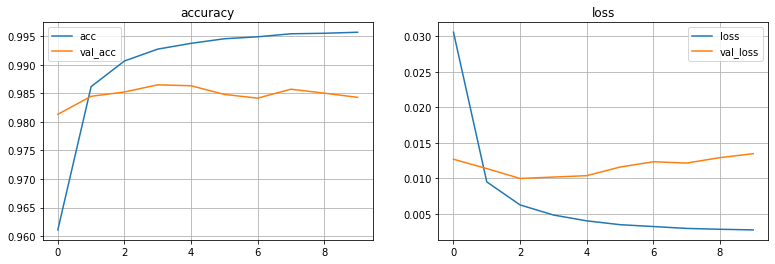

In [6]:
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [7]:
# 시퀀스 NER 태그로 변환
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace("PAD", "0"))
            result.append(temp)
    return result

y_predicted = model.predict(x_test)
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print(classification_report(test_tags, pred_tags))
print("F1-score : {:.2%}".format(f1_score(test_tags, pred_tags)))

/home/sigmoid/anaconda3/envs/kjt37/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sigmoid/anaconda3/envs/kjt37/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sigmoid/anaconda3/envs/kjt37/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_FOOD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sigmoid/anaconda3/envs/kjt37/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/sigmoid/anaconda3/envs/kjt37/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_PS seems not to be NE tag.
  warnings.warn('{} seems n

              precision    recall  f1-score   support

          NP       1.00      1.00      1.00      6920
           _       0.47      0.59      0.52     12360
         _DT       1.00      1.00      1.00    271840
       _FOOD       1.00      1.00      1.00    233280
         _LC       0.71      0.56      0.63      8160
         _OG       0.44      0.52      0.48      8760
         _PS       0.61      0.56      0.58      7960
         _TI       0.67      0.86      0.76      1440

   micro avg       0.96      0.97      0.97    550720
   macro avg       0.74      0.76      0.75    550720
weighted avg       0.97      0.97      0.97    550720

F1-score : 96.59%
